# Submission by:
    Nehali Parulekar
    Ayush Vashistha
    Rohit Goswami
    Priya Lenkennavar

In [54]:
import warnings
import gc

import numpy as np

warnings.filterwarnings("ignore")


def apk(t: list, y: list, k: int = 12, default: float = 0.0):
    
    # Extract prediction number of k data
    if len(y) > k:
        y = y[:k]

    score = 0.0

    # Number of predicts in actual vector
    num_hits = 0

    for i, pred in enumerate(y):
        if pred in t and pred not in y[:i]:  # predict in actual and don't duplicate
            num_hits += 1
            score += num_hits / (i+1)

    # If actual data doesn't have label
    if not t:
        return default

    # average precision
    return score / min(len(t), k)


def mapk(t: np.ndarray, y: np.ndarray, k: int = 12, default: float = 0.0):
    
    return np.mean([apk(tt, yy, k, default) for tt, yy in zip(t, y)])

In [2]:
# Test this function by using an example
pred = [2, 3, 1]
label = [2, 4, 1]

print(apk(label, pred))
print(5 / 9)

0.5555555555555555
0.5555555555555556


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)


# Transform from hexadecimal to decimal number
# from str(64bytes) to int(64bits)
def hex_id_to_int(string):
    return int(string[-16:], 16)


# Transform from int(64bits) to int(32bits)
def article_id_str_to_int(series):
    return series.astype("int32")

# Transform(from int 32bits to strings) and pre zero padding
def article_id_int_to_str(series):
    return "0" + series.astype("str")

In [4]:
import os
import pandas as pd

# Load Data
#DIR = "../input/h-and-m-personalized-fashion-recommendations"
transactions = pd.read_csv(os.path.join("transactions_train.csv", "transactions_train.csv"))
articles = pd.read_csv(os.path.join("articles.csv", "articles.csv"))
customers = pd.read_csv(os.path.join("customers.csv", "customers.csv"))

# Use "customer_hex_id_to_int"
display(customers["customer_id"])  # Original data
display(customer_hex_id_to_int(customers["customer_id"]))  # Applied data

0          00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1          0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2          000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3          00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4          00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
                                 ...                        
1371975    ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...
1371976    ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...
1371977    ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...
1371978    ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...
1371979    ffffd9ac14e89946416d80e791d064701994755c3ab686...
Name: customer_id, Length: 1371980, dtype: object

0           6883939031699146327
1          11246327431398957306
2          18439897732908966680
3          18352672461570950206
4          18162778555210377306
                   ...         
1371975     7551062398649767985
1371976     9305341941720086711
1371977    10160427316885688932
1371978     2551401172826382186
1371979    16929951892735599169
Name: customer_id, Length: 1371980, dtype: uint64

In [5]:
# Use "article_id_str_to_int" and "atticle_id_int_to_str"
display(transactions["article_id"])   # Original data
display(article_id_str_to_int(transactions["article_id"]))  # Transform from int64 to int 32
display(article_id_int_to_str(transactions["article_id"]))  # Transform from int to str and zero padding

0           663713001
1           541518023
2           505221004
3           685687003
4           685687004
              ...    
31788319    929511001
31788320    891322004
31788321    918325001
31788322    833459002
31788323    898573003
Name: article_id, Length: 31788324, dtype: int64

0           663713001
1           541518023
2           505221004
3           685687003
4           685687004
              ...    
31788319    929511001
31788320    891322004
31788321    918325001
31788322    833459002
31788323    898573003
Name: article_id, Length: 31788324, dtype: int32

0           0663713001
1           0541518023
2           0505221004
3           0685687003
4           0685687004
               ...    
31788319    0929511001
31788320    0891322004
31788321    0918325001
31788322    0833459002
31788323    0898573003
Name: article_id, Length: 31788324, dtype: object

In [6]:
# Implement feature transformer(as StandardScaler, LabelEncoder etc...)
class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples: int = 0):
        self.min_examples = min_examples
        self.categories = []

    def fit(self, X):
        for i in range(X.shape[1]):  # X.shape[1] is num of the features
            vc = X.iloc[:, i].values_counts()  # count num of the each values in the column
            self.categories.append(vc[vc > self.min_examples].index.tolist())

        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)

In [7]:
def calculate_apk(list_of_preds, list_of_labels):
    map_scores = []
    # Calculate MAP@12 for each customer prediction
    for preds, labels in zip(list_of_preds, list_of_labels):
        map_scores.append(map(preds, labels, k=12))

    # Average score
    return np.mean(map_scores)

In [8]:
# Create new columns
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions["year"] = transactions["t_dat"].dt.year

shape_2018 = transactions.query("year == 2018").shape[0]
shape_2019 = transactions.query("year == 2019").shape[0] + shape_2018
shape_2020 = transactions.query("year == 2020").shape[0] + shape_2019

transactions["week"] = transactions["t_dat"].dt.week
transactions.loc[shape_2018:shape_2019-1, "week"] = transactions.loc[shape_2018:shape_2019-1, "week"] + transactions.query("year == 2018")["week"].max() - 1
transactions.loc[shape_2019:shape_2020-1, "week"] = transactions.loc[shape_2019:shape_2020-1, "week"] + transactions.query("year == 2019")["week"].max() - 1
transactions["week"] = transactions["week"] - 37

transactions = transactions.query("t_dat >= '2020-07-15'")
display(transactions)
display(transactions.groupby(["week"])["t_dat"].agg(["min", "max"]))

,t_dat,customer_id,article_id,price,sales_channel_id,year,week
29025452,2020-07-15,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,796239001,0.022017,2,2020,94
29025453,2020-07-15,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,880696008,0.084729,2,2020,94
29025454,2020-07-15,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,880696008,0.084729,2,2020,94
29025455,2020-07-15,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,885827001,0.050831,2,2020,94
29025456,2020-07-15,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,868544001,0.025407,2,2020,94
...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2,2020,104
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2,2020,104
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1,2020,104
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1,2020,104


,min,max
week,,
94,2020-07-15,2020-07-19
95,2020-07-20,2020-07-26
96,2020-07-27,2020-08-02
97,2020-08-03,2020-08-09
98,2020-08-10,2020-08-16
99,2020-08-17,2020-08-23
100,2020-08-24,2020-08-30
101,2020-08-31,2020-09-06
102,2020-09-07,2020-09-13


In [9]:
# List of weeks when customer bought an article.
# Transform "custoemr_id" hexadecimal to decimal number
transactions["customer_id"] = customer_hex_id_to_int(transactions["customer_id"])

# To merge customers and transactions so transform "customer_id" as same
customers["customer_id"] = customer_hex_id_to_int(customers["customer_id"])

# Results is slightly different due to day of the start week is Monday
c2weeks = transactions.groupby(["customer_id"])["week"].unique()
display(c2weeks)

customer_id
28847241659200          [94, 95, 101]
41318098387474                   [97]
116809474287335            [100, 102]
200292573348128         [95, 98, 101]
248294615847351                  [95]
                            ...      
18446624797007271432             [95]
18446630855572834764            [103]
18446662237889060501             [99]
18446705133201055310            [101]
18446737527580148316            [104]
Name: week, Length: 437365, dtype: object

In [10]:
# Test week is the week after the last data of the train data
test_week = transactions["week"].max() + 1

c2weeks2shifted_weeks = dict()

for c_id, weeks in c2weeks.items():  # customer_id and list of weeks when the customer bought an article.
    c2weeks2shifted_weeks[c_id] = dict()
    for i in range(weeks.shape[0]-1):
        # key: the week when customer bought an article value: the week when customer bought an article next.
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

# Display an example
print(c2weeks2shifted_weeks[28847241659200])

{94: 95, 95: 101, 101: 105}


In [11]:
# Copy transactions data and week is replaced the customer bought and article next
candidates_last_purchase = transactions.copy()

weeks = []
# Create list to replace with next week by using dict
for i, (c_id, week) in enumerate(zip(transactions["customer_id"], transactions["week"])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])

candidates_last_purchase["week"] = weeks

# Display replace data
display(candidates_last_purchase[candidates_last_purchase['customer_id']==272412481300040])

# Display original transactions data to compare
display(transactions[transactions['customer_id']==272412481300040])

,t_dat,customer_id,article_id,price,sales_channel_id,year,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,2020,95
29030504,2020-07-15,272412481300040,816592008,0.016932,1,2020,95
29030505,2020-07-15,272412481300040,621381021,0.033881,1,2020,95
29030506,2020-07-15,272412481300040,817477003,0.025407,1,2020,95
29030507,2020-07-15,272412481300040,899088002,0.025407,1,2020,95
29319533,2020-07-22,272412481300040,885077001,0.008458,1,2020,96
29410772,2020-07-24,272412481300040,850176003,0.029034,2,2020,96
29410773,2020-07-24,272412481300040,875803001,0.064559,2,2020,96
29410774,2020-07-24,272412481300040,892970003,0.020966,2,2020,96
29410775,2020-07-24,272412481300040,854619003,0.020966,2,2020,96


,t_dat,customer_id,article_id,price,sales_channel_id,year,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,2020,94
29030504,2020-07-15,272412481300040,816592008,0.016932,1,2020,94
29030505,2020-07-15,272412481300040,621381021,0.033881,1,2020,94
29030506,2020-07-15,272412481300040,817477003,0.025407,1,2020,94
29030507,2020-07-15,272412481300040,899088002,0.025407,1,2020,94
29319533,2020-07-22,272412481300040,885077001,0.008458,1,2020,95
29410772,2020-07-24,272412481300040,850176003,0.029034,2,2020,95
29410773,2020-07-24,272412481300040,875803001,0.064559,2,2020,95
29410774,2020-07-24,272412481300040,892970003,0.020966,2,2020,95
29410775,2020-07-24,272412481300040,854619003,0.020966,2,2020,95


In [12]:
# Calculate mean price for a week
mean_price = transactions.groupby(["week", "article_id"])["price"].mean()

display(mean_price)

week  article_id
94    108775044     0.008458
      110065001     0.006085
      111565001     0.004517
      111586001     0.011455
      111593001     0.012240
                      ...   
104   952267001     0.016136
      952938001     0.050831
      953450001     0.016932
      953763001     0.021807
      956217002     0.058672
Name: price, Length: 206009, dtype: float64

In [13]:
sales = transactions \
    .groupby(["week"])["article_id"].value_counts() \
    .groupby(["week"]).rank(method="dense", ascending=False) \
    .groupby(["week"]).head(12).rename("bestseller_rank").astype("int8")

display(sales)

week  article_id
94    760084003      1
      866731001      2
      600886001      3
      547780003      4
      877278002      5
                    ..
104   788575004      8
      915529003      9
      918292001     10
      923758001     11
      928206001     11
Name: bestseller_rank, Length: 132, dtype: int8

In [14]:
# Divide their processings to understand what did in this code 
# line 1

# Count number of sold articles in each week
display(transactions.groupby(["week"])["article_id"].value_counts())

week  article_id
94    760084003     400
      866731001     383
      600886001     362
      547780003     336
      877278002     322
                   ... 
104   947253001       1
      947599001       1
      948152002       1
      949551002       1
      952267001       1
Name: article_id, Length: 206009, dtype: int64

In [15]:
# line 2
# Ranking by number of sold per week and descending sort
display(transactions.groupby(["week"])["article_id"].value_counts() \
        .groupby(["week"]).rank(method="dense", ascending=False))

week  article_id
94    760084003       1.0
      866731001       2.0
      600886001       3.0
      547780003       4.0
      877278002       5.0
                    ...  
104   947253001     113.0
      947599001     113.0
      948152002     113.0
      949551002     113.0
      952267001     113.0
Name: article_id, Length: 206009, dtype: float64

In [16]:
# line 3
# Extract top 12 articles each week and transform int type
display(transactions \
        .groupby(["week"])["article_id"].value_counts() \
        .groupby(["week"]).rank(method="dense", ascending=False) \
        .groupby(["week"]).head(12).rename("bestseller_rank").astype("int8"))

week  article_id
94    760084003      1
      866731001      2
      600886001      3
      547780003      4
      877278002      5
                    ..
104   788575004      8
      915529003      9
      918292001     10
      923758001     11
      928206001     11
Name: bestseller_rank, Length: 132, dtype: int8

In [17]:
# Merge data
bestsellers_previous_week = pd.merge(sales, mean_price, on=["week", "article_id"]).reset_index()
bestsellers_previous_week["week"] += 1

display(bestsellers_previous_week.query("week == 95"))

,week,article_id,bestseller_rank,price
0,95,760084003,1,0.025047
1,95,866731001,2,0.024918
2,95,600886001,3,0.022215
3,95,547780003,4,0.024852
4,95,877278002,5,0.025010
5,95,706016001,6,0.033282
6,95,372860002,7,0.013184
7,95,610776002,8,0.008354
8,95,372860001,9,0.013142
9,95,866383006,10,0.022587


In [18]:
# This code is equal following
# transactions.drop_duplicates(["week", "customer_id"])
unique_transactions = transactions \
    .groupby(["week", "customer_id"]) \
    .head(1) \
    .drop(columns=["article_id", "price"]) \
    .copy()

display(unique_transactions)

,t_dat,customer_id,sales_channel_id,year,week
29025452,2020-07-15,1249760199313500820,2,2020,94
29025461,2020-07-15,8092257515022405391,1,2020,94
29025463,2020-07-15,1261129818942802075,1,2020,94
29025464,2020-07-15,8055340703569116761,2,2020,94
29025467,2020-07-15,16284473745900982215,1,2020,94
...,...,...,...,...,...
31788310,2020-09-22,13026375591141062321,2,2020,104
31788319,2020-09-22,4685485978980270934,2,2020,104
31788321,2020-09-22,3959348689921271969,1,2020,104
31788322,2020-09-22,9807404028332039951,1,2020,104


In [19]:
# Merge data
candidates_bestsellers = pd.merge(unique_transactions, bestsellers_previous_week, on="week")

display(candidates_bestsellers)

,t_dat,customer_id,sales_channel_id,year,week,article_id,bestseller_rank,price
0,2020-07-20,7602665576689920481,1,2020,95,760084003,1,0.025047
1,2020-07-20,7602665576689920481,1,2020,95,866731001,2,0.024918
2,2020-07-20,7602665576689920481,1,2020,95,600886001,3,0.022215
3,2020-07-20,7602665576689920481,1,2020,95,547780003,4,0.024852
4,2020-07-20,7602665576689920481,1,2020,95,877278002,5,0.025010
...,...,...,...,...,...,...,...,...
8429419,2020-09-22,3235222691137941515,2,2020,104,751471001,8,0.033363
8429420,2020-09-22,3235222691137941515,2,2020,104,915529005,9,0.033394
8429421,2020-09-22,3235222691137941515,2,2020,104,866731001,10,0.024971
8429422,2020-09-22,3235222691137941515,2,2020,104,762846027,11,0.025068


In [20]:
test_set_transactions = unique_transactions.drop_duplicates("customer_id").reset_index(drop=True)
test_set_transactions["week"] = test_week

display(test_set_transactions)

,t_dat,customer_id,sales_channel_id,year,week
0,2020-07-15,1249760199313500820,2,2020,105
1,2020-07-15,8092257515022405391,1,2020,105
2,2020-07-15,1261129818942802075,1,2020,105
3,2020-07-15,8055340703569116761,2,2020,105
4,2020-07-15,16284473745900982215,1,2020,105
...,...,...,...,...,...
437360,2020-09-22,5804240836826735721,2,2020,105
437361,2020-09-22,9755849368273335309,2,2020,105
437362,2020-09-22,8957770126463084454,2,2020,105
437363,2020-09-22,10144351619255084097,2,2020,105


In [21]:
# Transactions data last bought before test term and best sellers
candidates_bestsellers_test_week = pd.merge(test_set_transactions,
                                            bestsellers_previous_week,
                                            on="week")

display(candidates_bestsellers_test_week)

,t_dat,customer_id,sales_channel_id,year,week,article_id,bestseller_rank,price
0,2020-07-15,1249760199313500820,2,2020,105,924243002,1,0.041668
1,2020-07-15,1249760199313500820,2,2020,105,448509014,2,0.041797
2,2020-07-15,1249760199313500820,2,2020,105,751471001,3,0.033548
3,2020-07-15,1249760199313500820,2,2020,105,866731001,4,0.025051
4,2020-07-15,1249760199313500820,2,2020,105,918522001,5,0.041628
...,...,...,...,...,...,...,...,...
5248375,2020-09-22,17895170066548165620,2,2020,105,788575004,8,0.042042
5248376,2020-09-22,17895170066548165620,2,2020,105,915529003,9,0.033494
5248377,2020-09-22,17895170066548165620,2,2020,105,918292001,10,0.041699
5248378,2020-09-22,17895170066548165620,2,2020,105,923758001,11,0.033322


In [22]:
# Merge train term data and test term data
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])

# drop bestseller_rank column
candidates_bestsellers = candidates_bestsellers.drop("bestseller_rank", axis=1)
display(candidates_bestsellers)

,t_dat,customer_id,sales_channel_id,year,week,article_id,price
0,2020-07-20,7602665576689920481,1,2020,95,760084003,0.025047
1,2020-07-20,7602665576689920481,1,2020,95,866731001,0.024918
2,2020-07-20,7602665576689920481,1,2020,95,600886001,0.022215
3,2020-07-20,7602665576689920481,1,2020,95,547780003,0.024852
4,2020-07-20,7602665576689920481,1,2020,95,877278002,0.025010
...,...,...,...,...,...,...,...
5248375,2020-09-22,17895170066548165620,2,2020,105,788575004,0.042042
5248376,2020-09-22,17895170066548165620,2,2020,105,915529003,0.033494
5248377,2020-09-22,17895170066548165620,2,2020,105,918292001,0.041699
5248378,2020-09-22,17895170066548165620,2,2020,105,923758001,0.033322


In [23]:
# Add new column
transactions["purchased"] = 1

data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data["purchased"] = data["purchased"].fillna(0)

display(head)

,t_dat,customer_id,article_id,price,sales_channel_id,year,week,purchased
29025452,2020-07-15,1249760199313500820,796239001,0.022017,2,2020,94,1.0
29025453,2020-07-15,1249760199313500820,880696008,0.084729,2,2020,94,1.0
29025454,2020-07-15,1249760199313500820,880696008,0.084729,2,2020,94,1.0
29025455,2020-07-15,1249760199313500820,885827001,0.050831,2,2020,94,1.0
29025456,2020-07-15,1249760199313500820,868544001,0.025407,2,2020,94,1.0
...,...,...,...,...,...,...,...,...
5248375,2020-09-22,17895170066548165620,788575004,0.042042,2,2020,105,0.0
5248376,2020-09-22,17895170066548165620,915529003,0.033494,2,2020,105,0.0
5248377,2020-09-22,17895170066548165620,918292001,0.041699,2,2020,105,0.0
5248378,2020-09-22,17895170066548165620,923758001,0.033322,2,2020,105,0.0


In [24]:
# Drop duplicate data
data = data.drop_duplicates(["customer_id", "article_id", "week"])

# Rate of purchased articles data
print(data["purchased"].mean())

0.134042353871098


In [25]:
# Add "bestseller_rank"
data = pd.merge(data, bestsellers_previous_week[["week", "article_id", "bestseller_rank"]],
                on=["week", "article_id"], how="left")
display(data)

,t_dat,customer_id,article_id,price,sales_channel_id,year,week,purchased,bestseller_rank
0,2020-07-15,1249760199313500820,796239001,0.022017,2,2020,94,1.0,NaN
1,2020-07-15,1249760199313500820,880696008,0.084729,2,2020,94,1.0,NaN
2,2020-07-15,1249760199313500820,885827001,0.050831,2,2020,94,1.0,NaN
3,2020-07-15,1249760199313500820,868544001,0.025407,2,2020,94,1.0,NaN
4,2020-07-15,1249760199313500820,888519001,0.030492,2,2020,94,1.0,NaN
...,...,...,...,...,...,...,...,...,...
18541724,2020-09-22,17895170066548165620,788575004,0.042042,2,2020,105,0.0,8.0
18541725,2020-09-22,17895170066548165620,915529003,0.033494,2,2020,105,0.0,9.0
18541726,2020-09-22,17895170066548165620,918292001,0.041699,2,2020,105,0.0,10.0
18541727,2020-09-22,17895170066548165620,923758001,0.033322,2,2020,105,0.0,11.0


In [26]:
# Drop first week data
data = data[data["week"] != data["week"].min()]

# Fill data not in bestseller articles
data["bestseller_rank"] = data["bestseller_rank"].fillna(999)

display(data)

,t_dat,customer_id,article_id,price,sales_channel_id,year,week,purchased,bestseller_rank
186798,2020-07-20,7602665576689920481,854338008,0.016932,1,2020,95,1.0,999.0
186799,2020-07-20,7602665576689920481,684209026,0.015237,1,2020,95,1.0,999.0
186800,2020-07-20,7602665576689920481,844294002,0.015237,1,2020,95,1.0,999.0
186801,2020-07-20,7602665576689920481,599580061,0.008458,1,2020,95,1.0,999.0
186802,2020-07-20,6764582912434543496,787946003,0.016932,1,2020,95,1.0,999.0
...,...,...,...,...,...,...,...,...,...
18541724,2020-09-22,17895170066548165620,788575004,0.042042,2,2020,105,0.0,8.0
18541725,2020-09-22,17895170066548165620,915529003,0.033494,2,2020,105,0.0,9.0
18541726,2020-09-22,17895170066548165620,918292001,0.041699,2,2020,105,0.0,10.0
18541727,2020-09-22,17895170066548165620,923758001,0.033322,2,2020,105,0.0,11.0


In [27]:
# Merge data articles and customers
data = pd.merge(data, articles, on="article_id", how="left")
data = pd.merge(data, customers, on="customer_id", how="left")

del transactions, unique_transactions, articles, customers
gc.collect()

display(data)

,t_dat,customer_id,article_id,price,sales_channel_id,year,week,purchased,bestseller_rank,product_code,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2020-07-20,7602665576689920481,854338008,0.016932,1,2020,95,1.0,999.0,854338,...,"Womens Swimwear, beachwear",1018,Swimwear,"Lined, non-wired triangle bikini top with ties...",NaN,NaN,ACTIVE,NONE,33.0,9ac195fbf122c4abe5d006c99c8fc18e7fa8447a96e0c1...
1,2020-07-20,7602665576689920481,684209026,0.015237,1,2020,95,1.0,999.0,684209,...,"Womens Swimwear, beachwear",1018,Swimwear,"Lined, non-wired, triangle bikini top with a w...",NaN,NaN,ACTIVE,NONE,33.0,9ac195fbf122c4abe5d006c99c8fc18e7fa8447a96e0c1...
2,2020-07-20,7602665576689920481,844294002,0.015237,1,2020,95,1.0,999.0,844294,...,"Womens Swimwear, beachwear",1018,Swimwear,"Strapless, lined balconette bikini top with un...",NaN,NaN,ACTIVE,NONE,33.0,9ac195fbf122c4abe5d006c99c8fc18e7fa8447a96e0c1...
3,2020-07-20,7602665576689920481,599580061,0.008458,1,2020,95,1.0,999.0,599580,...,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini bottoms with a mid waist an...,NaN,NaN,ACTIVE,NONE,33.0,9ac195fbf122c4abe5d006c99c8fc18e7fa8447a96e0c1...
4,2020-07-20,6764582912434543496,787946003,0.016932,1,2020,95,1.0,999.0,787946,...,Womens Everyday Basics,1002,Jersey Basic,Fitted vest tops in organic cotton jersey.,NaN,NaN,ACTIVE,NONE,47.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354926,2020-09-22,17895170066548165620,788575004,0.042042,2,2020,105,0.0,8.0,788575,...,Divided Collection,1009,Trousers,"Jeans in washed, stretch denim with a high wai...",NaN,NaN,ACTIVE,NONE,46.0,3452a70a3d2dd957d9612ec37d3e2ddd4eebaf8c5f1415...
18354927,2020-09-22,17895170066548165620,915529003,0.033494,2,2020,105,0.0,9.0,915529,...,Womens Everyday Collection,1003,Knitwear,"Jumper in a soft, fine knit containing some wo...",NaN,NaN,ACTIVE,NONE,46.0,3452a70a3d2dd957d9612ec37d3e2ddd4eebaf8c5f1415...
18354928,2020-09-22,17895170066548165620,918292001,0.041699,2,2020,105,0.0,10.0,918292,...,Ladies H&M Sport,1005,Jersey Fancy,Sports tights in fast-drying functional fabric...,NaN,NaN,ACTIVE,NONE,46.0,3452a70a3d2dd957d9612ec37d3e2ddd4eebaf8c5f1415...
18354929,2020-09-22,17895170066548165620,923758001,0.033322,2,2020,105,0.0,11.0,923758,...,Womens Everyday Collection,1010,Blouses,"Wide shirt in a cotton weave with a collar, bu...",NaN,NaN,ACTIVE,NONE,46.0,3452a70a3d2dd957d9612ec37d3e2ddd4eebaf8c5f1415...


In [28]:
# to store memory
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no',
                  'colour_group_code', 'perceived_colour_value_id',
                  'perceived_colour_master_id', 'department_no', 'index_code',
                  'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
                  'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
                  'bestseller_rank']
data = data[["customer_id", "week", "sales_channel_id", "purchased"]+columns_to_use]
data["postal_code"]=data["postal_code"].astype(str)
data["postal_code"] = customer_hex_id_to_int(data["postal_code"])

gc.collect()

# Sort data and reset index
data = data.sort_values(["week", "customer_id"]).reset_index(drop=True)
display(data)

,customer_id,week,sales_channel_id,purchased,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,...,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
0,28847241659200,95,1,1.0,887770001,253,1010016,9,4,5,...,1,6,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
1,28847241659200,95,1,0.0,762846001,259,1010016,10,3,9,...,1,11,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
2,28847241659200,95,1,0.0,829308001,273,1010016,9,4,5,...,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
3,28847241659200,95,1,0.0,760084003,272,1010016,9,4,5,...,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,1.0
4,28847241659200,95,1,0.0,866731001,273,1010016,9,4,5,...,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354926,18446737527580148316,105,2,0.0,788575004,272,1010023,73,4,2,...,2,53,1009,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,8.0
18354927,18446737527580148316,105,2,0.0,915529003,252,1010016,9,4,5,...,1,15,1003,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,9.0
18354928,18446737527580148316,105,2,0.0,918292001,273,1010010,9,4,5,...,26,5,1005,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,10.0
18354929,18446737527580148316,105,2,0.0,923758001,-1,1010016,10,3,9,...,1,15,1010,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,11.0


In [29]:
# Divide train data and test data
train = data[data["week"] != test_week]
test = data[data["week"] == test_week].drop_duplicates(["customer_id", "article_id", "sales_channel_id"]).copy()

display(train)
display(test)

,customer_id,week,sales_channel_id,purchased,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,...,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
0,28847241659200,95,1,1.0,887770001,253,1010016,9,4,5,...,1,6,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
1,28847241659200,95,1,0.0,762846001,259,1010016,10,3,9,...,1,11,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
2,28847241659200,95,1,0.0,829308001,273,1010016,9,4,5,...,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
3,28847241659200,95,1,0.0,760084003,272,1010016,9,4,5,...,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,1.0
4,28847241659200,95,1,0.0,866731001,273,1010016,9,4,5,...,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11751390,18446737527580148316,104,2,0.0,751471001,272,1010016,9,4,5,...,1,15,1009,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,8.0
11751391,18446737527580148316,104,2,0.0,915529005,252,1010016,13,1,1,...,1,15,1003,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,9.0
11751392,18446737527580148316,104,2,0.0,866731001,273,1010016,9,4,5,...,26,5,1005,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,10.0
11751393,18446737527580148316,104,2,0.0,762846027,259,1010016,13,1,1,...,1,11,1010,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,11.0


,customer_id,week,sales_channel_id,purchased,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,...,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
11751395,28847241659200,105,1,0.0,760084003,272,1010016,9,4,5,...,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
11751396,28847241659200,105,2,0.0,925246001,262,1010016,9,4,5,...,1,19,1007,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
11751397,28847241659200,105,1,0.0,924243002,252,1010016,9,4,5,...,1,15,1003,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,1.0
11751398,28847241659200,105,1,0.0,448509014,272,1010016,72,3,2,...,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,2.0
11751399,28847241659200,105,1,0.0,751471001,272,1010016,9,4,5,...,1,15,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354926,18446737527580148316,105,2,0.0,788575004,272,1010023,73,4,2,...,2,53,1009,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,8.0
18354927,18446737527580148316,105,2,0.0,915529003,252,1010016,9,4,5,...,1,15,1003,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,9.0
18354928,18446737527580148316,105,2,0.0,918292001,273,1010010,9,4,5,...,26,5,1005,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,10.0
18354929,18446737527580148316,105,2,0.0,923758001,-1,1010016,10,3,9,...,1,15,1010,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,11.0


In [30]:
# Number of articles that each customer bought
train_baskets = train.groupby(["week", "customer_id"])["article_id"].count().values
display(train.groupby(["week", "customer_id"])["article_id"].count())

week  customer_id         
95    28847241659200          15
      200292573348128         24
      248294615847351         16
      272412481300040         22
      366493139417506         14
                              ..
104   18441063240631620931    14
      18443633011701112574    15
      18444758577473533758    14
      18445164350380731040    13
      18446737527580148316    16
Name: article_id, Length: 702452, dtype: int64

In [31]:
# Define use columns to train model
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no',
                  'colour_group_code', 'perceived_colour_value_id',
                  'perceived_colour_master_id', 'department_no', 'index_code',
                  'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
                  'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
                  'bestseller_rank']
display(train[columns_to_use].head())
display(test[columns_to_use].head())

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
0,887770001,253,1010016,9,4,5,1510,A,1,6,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
1,762846001,259,1010016,10,3,9,1515,A,1,11,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
2,829308001,273,1010016,9,4,5,8310,S,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
3,760084003,272,1010016,9,4,5,1747,D,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,1.0
4,866731001,273,1010016,9,4,5,8310,S,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,2.0


,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
11751395,760084003,272,1010016,9,4,5,1747,D,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
11751396,925246001,262,1010016,9,4,5,1201,A,1,19,1007,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
11751397,924243002,252,1010016,9,4,5,1626,A,1,15,1003,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,1.0
11751398,448509014,272,1010016,72,3,2,1747,D,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,2.0
11751399,751471001,272,1010016,9,4,5,1722,A,1,15,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,3.0


In [32]:
train_X = train[columns_to_use]
train_y = train["purchased"]

test_X = test[columns_to_use]

display(train_X)
display(train_y)

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
0,887770001,253,1010016,9,4,5,1510,A,1,6,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
1,762846001,259,1010016,10,3,9,1515,A,1,11,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
2,829308001,273,1010016,9,4,5,8310,S,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0
3,760084003,272,1010016,9,4,5,1747,D,2,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,1.0
4,866731001,273,1010016,9,4,5,8310,S,26,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11751390,751471001,272,1010016,9,4,5,1722,A,1,15,1009,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,8.0
11751391,915529005,252,1010016,13,1,1,1626,A,1,15,1003,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,9.0
11751392,866731001,273,1010016,9,4,5,8310,S,26,5,1005,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,10.0
11751393,762846027,259,1010016,13,1,1,1515,A,1,11,1010,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,11.0


0           1.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
11751390    0.0
11751391    0.0
11751392    0.0
11751393    0.0
11751394    0.0
Name: purchased, Length: 11751395, dtype: float64

In [33]:
display(test[test["customer_id"] == 28847241659200][["article_id", "bestseller_rank"]])
display(test[test["customer_id"] == 41318098387474][["article_id", "bestseller_rank"]])

,article_id,bestseller_rank
11751395,760084003,999.0
11751396,925246001,999.0
11751397,924243002,1.0
11751398,448509014,2.0
11751399,751471001,3.0
11751400,866731001,4.0
11751401,918522001,5.0
11751402,714790020,6.0
11751403,930380001,7.0
11751404,788575004,8.0


,article_id,bestseller_rank
11751409,868879003,999.0
11751410,924243002,1.0
11751411,448509014,2.0
11751412,751471001,3.0
11751413,866731001,4.0
11751414,918522001,5.0
11751415,714790020,6.0
11751416,930380001,7.0
11751417,788575004,8.0
11751418,915529003,9.0


In [34]:
# Import model class
from lightgbm.sklearn import LGBMRanker

In [35]:
cat_columns = ["club_member_status",
               "fashion_news_frequency", "postal_code"]

display(train_X[cat_columns].describe())

for column in cat_columns:
    print(column)
    print(train_X[column].unique())

,postal_code
count,1.175140e+07
mean,9.212631e+18
std,5.250379e+18
min,1.238997e+14
25%,4.745831e+18
50%,9.408261e+18
75%,1.367212e+19
max,1.844668e+19


club_member_status
['ACTIVE' 'PRE-CREATE' nan 'LEFT CLUB']
fashion_news_frequency
['Regularly' 'NONE' nan 'Monthly']
postal_code
[ 2684761665381926373   529517615094017823 11507428772054945013 ...
 11532865031844961057  7939203433249044699 11503485268237007578]


In [36]:
# Preprocessing categorical values
from sklearn.preprocessing import LabelEncoder

# Replace "None" and "NONE" to np.nan
train_X["fashion_news_frequency"] = train_X["fashion_news_frequency"].replace({"None": np.nan,
                                                                               "NONE": np.nan})
test_X["fashion_news_frequency"] = test_X["fashion_news_frequency"].replace({"None": np.nan,
                                                                             "NONE": np.nan})
# Fill nan
train_X["club_member_status"] = train_X["club_member_status"].fillna("INACTIVE")
train_X["fashion_news_frequency"] = train_X["fashion_news_frequency"].fillna("NOT RECEIVE")

test_X["club_member_status"] = test_X["club_member_status"].fillna("INACTIVE")
test_X["fashion_news_frequency"] = test_X["fashion_news_frequency"].fillna("NOT RECEIVE")

# Label encode
cat_columns = ["index_code", "club_member_status", "fashion_news_frequency"]

for column in cat_columns:
    print(column)
    le = LabelEncoder()
    train_X[column] = le.fit_transform(train_X[column].values.reshape(-1))
    test_X[column] = le.transform(test_X[column].values.reshape(-1))

index_code
club_member_status
fashion_news_frequency


In [37]:
train_X.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
0,887770001,253,1010016,9,4,5,1510,0,1,6,1010,1.0,1.0,0,2,21.0,2684761665381926373,999.0
1,762846001,259,1010016,10,3,9,1515,0,1,11,1010,1.0,1.0,0,2,21.0,2684761665381926373,999.0
2,829308001,273,1010016,9,4,5,8310,9,26,5,1005,1.0,1.0,0,2,21.0,2684761665381926373,999.0
3,760084003,272,1010016,9,4,5,1747,3,2,53,1009,1.0,1.0,0,2,21.0,2684761665381926373,1.0
4,866731001,273,1010016,9,4,5,8310,9,26,5,1005,1.0,1.0,0,2,21.0,2684761665381926373,2.0


In [38]:
train_X.columns

Index(['article_id', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
       'bestseller_rank'],
      dtype='object')

In [39]:
train_y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: purchased, dtype: float64

In [40]:
train_y.value_counts()

0.0    9452816
1.0    2298579
Name: purchased, dtype: int64

In [41]:
# Class instance
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type="gain",
    verbose=10
)

# Fit model
ranker = ranker.fit(train_X, train_y, group=train_baskets)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.845257
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.119676
[LightGBM] [Debug] init for col-wise cost 0.185124 seconds, init for row-wise cost 0.507868 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.386762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 11751395, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9


In [42]:
# Display feature importances ratio
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.9991356360574001
age 0.0002339999619576384
article_id 0.0002303182954005313
department_no 8.663887714280454e-05
club_member_status 6.023656615274772e-05
product_type_no 5.81829070845049e-05
garment_group_no 4.694160278687171e-05
section_no 4.281516402177181e-05
fashion_news_frequency 2.3729787544429738e-05
colour_group_code 2.360010758273552e-05
perceived_colour_value_id 2.0930493844021284e-05
Active 1.4895957593182687e-05
graphical_appearance_no 1.2137967330640276e-05
index_code 9.936254158032773e-06
FN 0.0
postal_code 0.0
perceived_colour_master_id 0.0
index_group_no 0.0


In [43]:
test_X.columns

Index(['article_id', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
       'bestseller_rank'],
      dtype='object')

In [44]:
test_X_new=test_X[['bestseller_rank']]

In [45]:
# Create predict
test["preds"] = ranker.predict(test_X)

# Create dict. key: customer_id values: prediction
c_id2predicted_article_ids = test \
    .sort_values(["customer_id", "preds"], ascending=False) \
    .groupby(["customer_id"])["article_id"].apply(list).to_dict()

In [46]:
test

,customer_id,week,sales_channel_id,purchased,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,...,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank,preds
11751395,28847241659200,105,1,0.0,760084003,272,1010016,9,4,5,...,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0,0.175904
11751396,28847241659200,105,2,0.0,925246001,262,1010016,9,4,5,...,19,1007,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,999.0,0.175904
11751397,28847241659200,105,1,0.0,924243002,252,1010016,9,4,5,...,15,1003,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,1.0,-0.165248
11751398,28847241659200,105,1,0.0,448509014,272,1010016,72,3,2,...,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,2.0,-0.189812
11751399,28847241659200,105,1,0.0,751471001,272,1010016,9,4,5,...,15,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,3.0,-0.193081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18354926,18446737527580148316,105,2,0.0,788575004,272,1010023,73,4,2,...,53,1009,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,8.0,-0.193081
18354927,18446737527580148316,105,2,0.0,915529003,252,1010016,9,4,5,...,15,1003,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,9.0,-0.191127
18354928,18446737527580148316,105,2,0.0,918292001,273,1010010,9,4,5,...,5,1005,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,10.0,-0.193081
18354929,18446737527580148316,105,2,0.0,923758001,-1,1010016,10,3,9,...,15,1010,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,11.0,-0.194713


In [47]:
# How process in Create c_id2predicted_article_ids
display(test.sort_values(["customer_id", "preds"], ascending=False))

,customer_id,week,sales_channel_id,purchased,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,...,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank,preds
18354915,18446737527580148316,105,2,0.0,547780001,272,1010016,9,4,5,...,51,1002,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,999.0,0.173597
18354916,18446737527580148316,105,2,0.0,763988001,272,1010016,9,4,5,...,26,1002,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,999.0,0.170957
18354917,18446737527580148316,105,2,0.0,763988003,272,1010010,9,4,12,...,26,1002,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,999.0,0.170957
18354918,18446737527580148316,105,2,0.0,547780040,272,1010016,31,1,3,...,51,1002,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,999.0,0.165363
18354919,18446737527580148316,105,2,0.0,924243002,252,1010016,9,4,5,...,15,1003,1.0,1.0,ACTIVE,Regularly,60.0,11503485268237007578,1.0,-0.184143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11751404,28847241659200,105,1,0.0,788575004,272,1010023,73,4,2,...,53,1009,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,8.0,-0.193081
11751406,28847241659200,105,1,0.0,918292001,273,1010010,9,4,5,...,5,1005,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,10.0,-0.193081
11751403,28847241659200,105,1,0.0,930380001,258,1010001,31,1,3,...,15,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,7.0,-0.194713
11751407,28847241659200,105,1,0.0,923758001,-1,1010016,10,3,9,...,15,1010,1.0,1.0,ACTIVE,Regularly,21.0,2684761665381926373,11.0,-0.194713


In [48]:
display(test.sort_values(["customer_id", "preds"], ascending=False).groupby(["customer_id"])["article_id"].apply(list))

customer_id
28847241659200          [760084003, 925246001, 924243002, 448509014, 9...
41318098387474          [868879003, 924243002, 448509014, 918522001, 9...
116809474287335         [906305002, 924243002, 448509014, 918522001, 9...
200292573348128         [903861001, 924243002, 448509014, 918522001, 9...
248294615847351         [720504008, 337991001, 471714002, 878987003, 9...
                                              ...                        
18446624797007271432    [556539027, 805308003, 832482004, 832482001, 9...
18446630855572834764    [898713001, 886966002, 568601045, 924243002, 4...
18446662237889060501    [915526002, 845790006, 924243002, 448509014, 9...
18446705133201055310    [875784002, 924243002, 448509014, 918522001, 9...
18446737527580148316    [547780001, 763988001, 763988003, 547780040, 9...
Name: article_id, Length: 437365, dtype: object

In [49]:
# Articles sold top 12
bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week["week"] == bestsellers_previous_week["week"].max()]["article_id"].tolist()
print(bestsellers_last_week)

[924243002, 448509014, 751471001, 866731001, 918522001, 714790020, 930380001, 788575004, 915529003, 918292001, 923758001, 928206001]


In [50]:
submission = pd.read_csv(os.path.join("sample_submission.csv", "sample_submission.csv"))
display(submission)

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0706016001 0706016002 0372860001 0610776002 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0706016001 0706016002 0372860001 0610776002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016001 0706016002 0372860001 0610776002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0706016001 0706016002 0372860001 0610776002 07...


In [51]:
preds = []

# Extract prediction using key(customer_id) and append list
for c_id in customer_hex_id_to_int(submission["customer_id"]):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week

    # Extract top 12 articles
    # If custoemr id is not in dict keys, pred is bestsellers_last_week
    preds.append(pred[:12])

for i in range(5):
    print(preds[i])

[568601043, 924243002, 448509014, 918522001, 915529003, 751471001, 866731001, 714790020, 788575004, 918292001, 930380001, 923758001]
[924243002, 448509014, 751471001, 866731001, 918522001, 714790020, 930380001, 788575004, 915529003, 918292001, 923758001, 928206001]
[794321007, 924243002, 448509014, 918522001, 915529003, 751471001, 866731001, 714790020, 788575004, 918292001, 930380001, 923758001]
[924243002, 448509014, 751471001, 866731001, 918522001, 714790020, 930380001, 788575004, 915529003, 918292001, 923758001, 928206001]
[896152002, 927530004, 730683050, 791587015, 924243002, 448509014, 918522001, 915529003, 751471001, 866731001, 714790020, 788575004]


In [52]:
# Pre zero padding to match submission format
# Create preds is same as following

preds = [" ".join(["0" + str(p) for p in ps]) for ps in preds]
submission["prediction"] = preds

submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0924243002 0448509014 0918522001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0924243002 0448509014 0751471001 0866731001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243002 0448509014 0918522001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243002 0448509014 0751471001 0866731001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0927530004 0730683050 0791587015 09...


In [53]:
submission.to_csv('submission.csv', index=False)

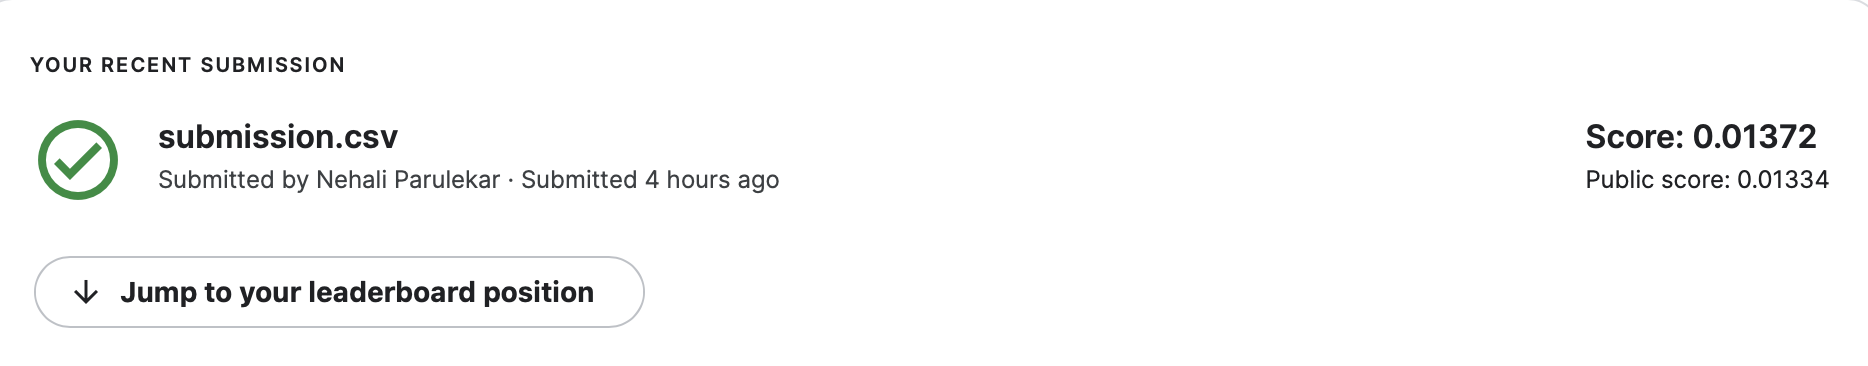

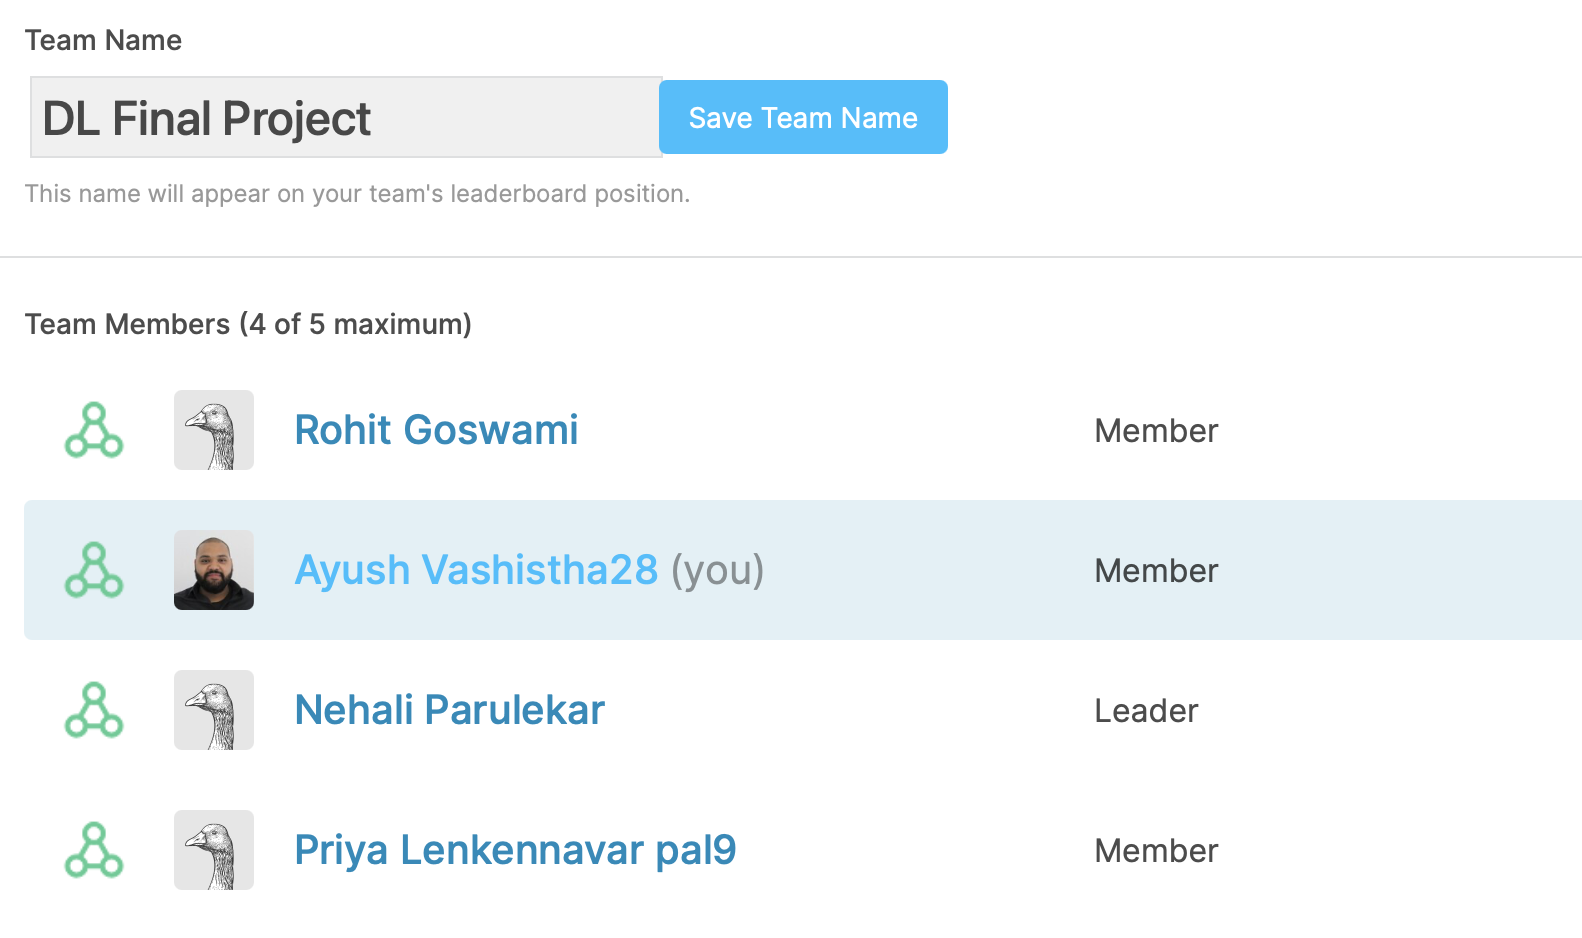